In [32]:
import itertools
from copy import deepcopy as copy
from scipy.linalg import fractional_matrix_power, block_diag
import networkx as nx
import cvxpy as cp
import matplotlib as mpl
import matplotlib.pyplot as plt 
import numpy as np
from operator import itemgetter
# from netgraph import InteractiveGraph # pip install netgraph
from functools import reduce
import scipy 
from numpy.linalg import matrix_rank as rank 
from Adversary import Problem, to_str, visualize, Adversary, hamming_dist as dist
from Solvers import type_mask, partial, ket, instance_mask, adv_solver
from ElementDistinctness import ED
from Examples import exact_k, threshold_k
from time import time
from itertools import product, permutations
mpl.rcParams["figure.dpi"] = 120
from multiprocessing.pool import ThreadPool as Pool

In [2]:
def get_oracles(funcs, oracle_getter, to_list=True):
    print('get_oracles', len(funcs))
    if to_list:
        return [oracle_getter(func) for func in funcs]
    return {func: oracle_getter(func) for func in funcs}

def cycle_oracle(func):
    return permutation_oracle(cycle_to_standard(func))

def get_phase_oracles(problem):
    oracles = {}
    # roots = nthRootsOfUnity(n)
    if isinstance(problem, Problem):
        instances = problem.instances
    n = len(instances[0])
    for instance in instances:
        oracle = np.zeros((n,n))
        for i in range(n):
            oracle[i, i] =-1 if instance[i] == 1 else 1
        oracles[instance] = oracle
        
    return oracles
def phase_oracle(func):
    oracle = np.zeros((len(func),len(func)))
    for i in range(len(func)):
        oracle[i,i] = func[i]
    return oracle 
def get_standard_oracles(problem):
    oracles = {}
    n = problem.n
    alpha_len = len(problem.alphabet)
    for instance in problem.instances:
        oracle = []
        for i in range(n):
            curr_oracle = np.zeros((alpha_len, alpha_len))
            for a in problem.alphabet:
                curr_oracle[a, (instance[i] + a) % alpha_len] = 1
            # print(curr_oracle)
            oracle.append(copy(curr_oracle))
        oracles[instance] = block_diag(*oracle)
        # print(oracles[instance])
    return oracles
def standard_oracle(func, alpha_len=None):
    n = len(func)
    if alpha_len is None:
        alpha_len = n
    oracle = []
    for i in range(n):
        curr_oracle = np.zeros((alpha_len, alpha_len))
        for a in range(alpha_len):
            curr_oracle[a, (func[i] + a) % alpha_len] = 1
            # print(curr_oracle)
        oracle.append(copy(curr_oracle))
    return block_diag(*oracle)

def get_oracle_diffs(oracles, prod=True, mat=False, keys=None, threads=8):
    n=oracles[0].shape[0]
    if np.linalg.norm(np.imag(np.block([oracles]))) == 0:
        oracle_diffs = np.zeros([n * len(oracles)]*2)
    else:
        print("complex time!")
        oracle_diffs = np.zeros([n * len(oracles)]*2, dtype=complex)
    # print("keys", keys)
    I = np.eye(oracles[0].shape[0])
    if keys is None:
        keys = list(range(len(oracles)))
    # keys.sort()
    keys = list(range(len(oracles)))
    def diff_map(v):
        v1, v2 = v
        return I - oracles[v1].conj().T @ oracles[v2]
    # counter = 0
    pool = Pool(threads)
    for v1 in keys:
        if not v1 % 100:
            print(v1/len(oracles))
        oracle_diffs[v1*n:(v1+1)*n] = np.hstack(pool.map(diff_map, list(product([v1], keys))))
    return oracle_diffs
def phase_oracle_diffs(perms):
    # phase_mats = [permutation_oracle(perm) for perm in perms]
    diffs = [[_ for _ in range(len(perms))] for _2 in range(len(perms))]
    # print('diffs', diffs)
    n = len(perms[0])
    for i in range(len(perms)):
        for j in range(len(perms)):
            diff = np.zeros((len(perms[i]), len(perms[i])))
            for r in range(n):
                # for c in range(n):
                if perms[i][r] != perms[j][r]:
                    diff[r,r] = 1
            # print('ij', i, j)
            diffs[i][j] = diff
    return diffs
    
def permutation_oracle(perm, nonstandard=False):
    n = len(perm)
    
    oracle = np.zeros((n, n))
    for i in range(n):
        oracle[perm[i], i] = 1
    return oracle

def get_permutation_oracles(instances):
    # assuming instances are all lists representing permutations
    oracles = {}
    n = len(instances[0])
    print(n)
    # assert tuple(range(n)) == problem.alphabet
    for instance in instances:
        oracle = np.zeros((n, n))
        for i in range(n):
            oracle[i, instance[i]] = 1
        oracles[instance] = oracle
        # assert oracle@oracle.T - np.eye(n)
    return oracles

def preimage_even_odd(n):
    perms = itertools.permutations(range(n))
    no_instances = []
    yes_instances = []
    for perm in get_cycles(n,n):
        # print(to_str(perm))
        if perm.index(0) >= n//2:
            yes_instances.append(perm)
        else:
            no_instances.append(perm)
    return Problem(no_instances, yes_instances)

In [3]:
def search_perm_sorter(perms):
    n = len(perms[0])
    print('n', n)
    perm_types = {i:[] for i in range(n)}
    for perm in perms:
        perm_types[perm.index(0)].append( perm)
    for t in perm_types:
        perm_types[t].sort()
    perm_assignment = {}
    curr_perm = 0
    for i, permsi in perm_types.items():
        permsi = list(permsi)
        for perm in permsi:
            perm_assignment[perm] = curr_perm
            curr_perm += 1
    # print(perm_assignment)
    return perm_assignment, perm_types
# cycle_to_st
def search_mask(funcs, assignment=None, marker=0):
    size = len(funcs)
    if assignment is None:
        assignment = search_perm_sorter(funcs)
    if assignment == 'same':
        assignment = {funcs[i]: i for i in range(len(funcs))}
    # print(size)
    mask = np.zeros((size, size))
    for f in funcs:
        f0 = f.index(marker)
        for g in funcs:
            g0 = g.index(marker)
            if f0 != g0:
                mask[assignment[f], assignment[g]] = 1
    return mask
def index_or(n):
    funcs = list(set(itertools.permutations([1] + [0] * (n-1))))
    funcs.sort()
    print(funcs)
    size = len(funcs)
    return funcs, search_mask(funcs, assignment='same', marker=1)
# print(index_or(n))
def cycle_to_standard(cycle, nonstandard=True):
    n = len(cycle)
    if nonstandard:
        elements = list(cycle)
        elements.sort()
        cycle = tuple(elements.index(cycle[i]) for i in range(n))
    perm = list(range(n))
    for i in range(n):
        perm[cycle[i]] = cycle[(i+1)%n]
    return tuple(perm)
def get_shift(perm, k, l):
    # take p_{k+1}->...->p_l and insert and put it at the end
    # cycle_perm = get_all_cycles(perm)[0]
    # print('get_all cycles', perm, cycle_perm)
    shifted_cycle = perm[:k+1] + perm[l+1:] + perm[k+1: l+1]
    # print('shift', cycle_perm, shifted_cycle)
    # print(k, l, cycle_perm, shifted_cycle)
    # print(k,l, get_all_cycles(cyclecycle_perm)[0], get_all_cycles(shifted_cycle))
    # print(shifted_cycle)
    # print(cycle_to_standard(shifted_cycle)
    assert len(perm) == len(shifted_cycle) 
    return shifted_cycle

def get_all_k_shift(perm, k):
    n = len(perm)
    # print('shift', list({get_shift(perm, k, j) for j in range(k+1, n-1)}))
    return list({get_shift(perm, k, j) for j in range(k+1, n-1)})

def get_n_cycles(n):
    cycles = itertools.permutations(range(n))
    perms = set()
    for cycle in cycles:
        perm = list(range(n))
        for i in range(n):
            perm[cycle[i]] = cycle[(i+1)%n]
        perms.add(tuple(perm))
    return list(perms)

def lv_search_mat(n, shift=None):
    cycles = get_n_cycles(n)
    # print(cycles)
    search_perm_sorter(cycles)
    assignment, perm_types = search_perm_sorter(cycles)
    one_pairs = dict()
    for cycle in cycles:
        # print(cycle)
        # print(get_all_k_shift(cycle))
        one_pairs[cycle] = []
        if shift is None:
            for k in range(1, n-1):
                one_pairs[cycle] = one_pairs[cycle] + get_all_k_shift(cycle, k)
        else: 
            one_pairs[cycle] = get_all_k_shift(cycle, shift)
    # print('pairs', one_pairs)
    mat = np.zeros((len(cycles), len(cycles)))
    for cycle in cycles:
        for pair in one_pairs[cycle]:
            # print(cycles, pair)
            mat[assignment[cycle], assignment[pair]] = 1
    return mat
def get_special_cycles(n, m, decision=False):
    perm_items = list(product(range(n), range(m)))
    # print(perm_items)
    index_cycles = get_cycles(n*m)
    # print('got all cycles')
    # print(index_cycles)
    preimage_dict = {str(y):[] for y in range(1, n)}
    cycles = [tuple(to_str(perm_items[index_cycle[i]]) for i in range(n*m)) for index_cycle in index_cycles]
    special_cycles = []
    # print(cycles)
    bad_cycles = []
    for cycle in cycles:
        if cycle[-1][1]=='0':
            # print(cycle)
            special_cycles.append(cycle)
            preimage_dict[cycle[-1][0]].append(cycle)
        else:
            bad_cycles.append(cycle)
    if decision:
        assignment_special = cycle_sort(special_cycles)
        assignment_bad = cycle_sort(bad_cycles)
        all_cycles = special_cycles + bad_cycles
        assignment = {all_cycles[i]: i for i in range(len(all_cycles))}
        preimage_dict = {0: special_cycles, 1: bad_cycles}
        return all_cycles, assignment, preimage_dict
    
    assignment = cycle_sort(special_cycles)
    for v, i in assignment.items():
        special_cycles[i] = v
    
    # print('returning special cycles')
    return special_cycles, assignment, preimage_dict
# phase_oracle_diffs([cycle_to_standard(cycle) for cycle in perms
def get_cycles(n):
    cycles = []
    for perm in permutations(range(1, n)):
        cycles.append((0,) + perm)
    return cycles
def to_str(l):
    return ''.join(str(a) for a in l)
def list_to_str(L):
    return [to_str(l) for l in L] 

def cycle_sort(cycles):
    cycles.sort(key=itemgetter(-1))
    return {cycles[i]: i for i in range(len(cycles))}

def shift(cycle, l, k):
    cycle2 = cycle[:k+1] + cycle[l+1:] + cycle[k+1:l+1]
    return cycle2

def mask_maker(assignment, cases):
    mat = np.zeros((len(assignment), len(assignment)))
    for case1 in cases:
        for case2 in cases:
            if case1 != case2:
                for perm1 in cases[case1]:
                    for perm2 in cases[case2]:
                        # print('cases', case1, case2)
                        # print('perms',perm1, perm2)
                        mat[assignment[perm1], assignment[perm2]] = 1
    return mat

def function_erasure_mask(funcs, target=0):
    n = len(funcs[0])
    start_vects = []
    end_vects = []
    for func in funcs:
        inv = func.index(target)
        end_vect = np.zeros((n, n)) 
        end_vect[:, 0] = 1
        end_vect[inv,0] = 0
        start_vect = np.zeros((n,n))
        for i in range(n):
            if i != inv:
                start_vect[i, func[i]] = 1
        start_vects.append(start_vect)
        end_vects.append(end_vect)
    mask = np.zeros((len(funcs), len(funcs)))
    for i in range(len(funcs)):
        # print(start_vects[i])
        for j in range(len(funcs)):
            # print(end_vects[i])
            mask[i,j] = np.trace(start_vects[i].T@start_vects[j]) - np.trace(end_vects[i].T@end_vects[j])
    return mask
def nthRootsOfUnity2(n): # constant space, serial
    from cmath import exp, pi
    c = 2j * pi / n
    return [exp(k * c) for k in range(n)]
def real_phase_oracle(func):
    n = len(func)
    roots = nthRootsOfUnity2(n)
    oracle = np.zeros((n,n), dtype=complex)
    for i in range(n):
        oracle[i,i] = roots[func[i]]
    return oracle

def unitary_implementation(problem_mats):
    # problem_dict[i]=(oracle_i, unitary_i)
    n = problem_mats[0][0].shape[0]
    problem_index_to_label = list(product(range(len(problem_mats)), range(n)))
    label_to_index = {problem_index_to_label[i]: i for i in range(len(problem_mats))}
    size = len(problem_index_to_label)
    problem_mask = np.zeros((size, size), dtype=complex)
    print(problem_index_to_label)
    start_end_vectors = []
    for oracle, unitary in problem_mats:
        for i in range(n):
            start_end_vectors.append(((np.eye(1, n, i).T).T, (unitary@np.eye(1, n, i).T).T))
    
    for i in range(size):
        for j in range(size):
            start_i, end_i = start_end_vectors[i]
            start_j, end_j = start_end_vectors[j]    
            
            problem_mask[i,j] = np.inner(np.conj(start_i), start_j)[0,0] - np.inner(np.conj(end_i), start_j)[0,0]
    oracles_for_diff = [problem_mats[i][0] for _ in range(n) for i in range(len(problem_mats))]
    diffs = get_oracle_diffs(oracles_for_diff)
    return problem_mask, diffs

In [57]:
n= 4
m=1
cycles, assignment, preimage_dict = get_special_cycles(n, m)
oracles = get_oracles(cycles, cycle_oracle)
diffs = get_oracle_diffs(oracles)
problem_mask = mask_maker(assignment, preimage_dict)

cycle_labels = [to_str(cycle) for cycle in cycles]
diff_labels = list(product(cycle_labels, product(range(n), range(m))))
# visualize(diffs, (diff_labels, diff_labels))
# visualize(problem_mask, (cycle_labels, cycle_labels))
# Lambda, Y, W = relative_hadamard_norm_max(problem_mask, diffs, problem_mask.shape[0], uni=True)
# visualize(Lambda, [cycle_labels]*2, complex=True)
# visualize(Y,[cycle_labels]*2, complex=T)
# visualize(W, [diff_labels]*2, complex=True)

get_oracles 6
0.0


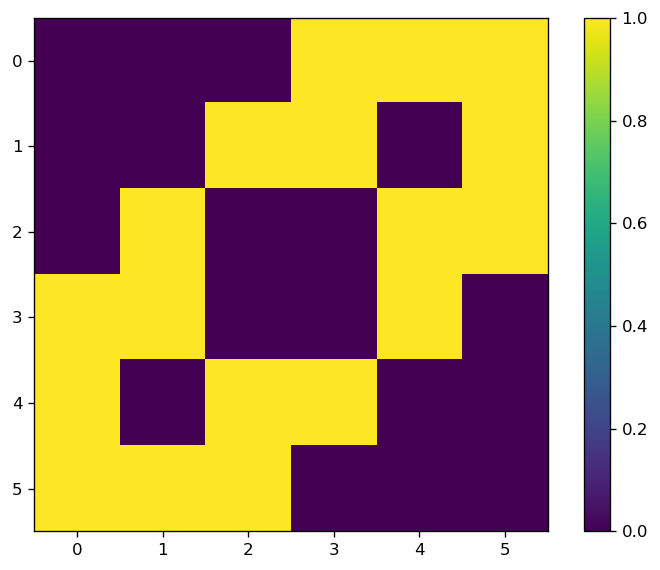

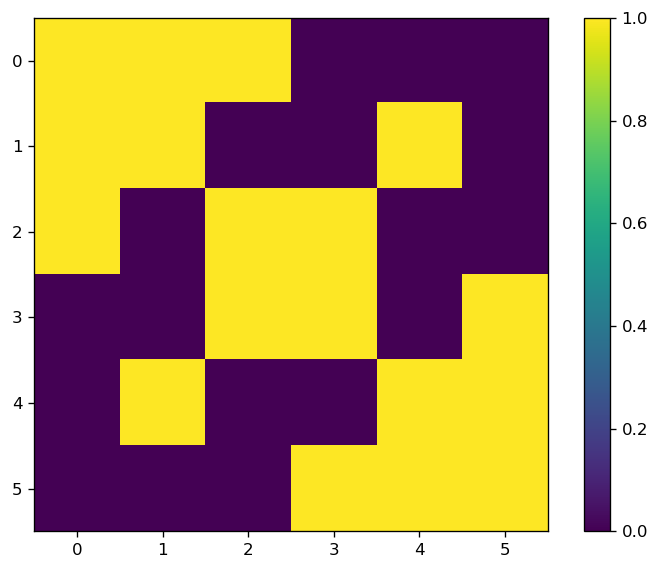

                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Oct 19 02:07:37 PM: Your problem has 36 variables, 1 constraints, and 0 parameters.
(CVXPY) Oct 19 02:07:37 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Oct 19 02:07:37 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Oct 19 02:07:37 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Oct 19 02:07:37 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Oct 19 02:07:37 PM: Compiling problem (target solver=MOSEK).
(CV

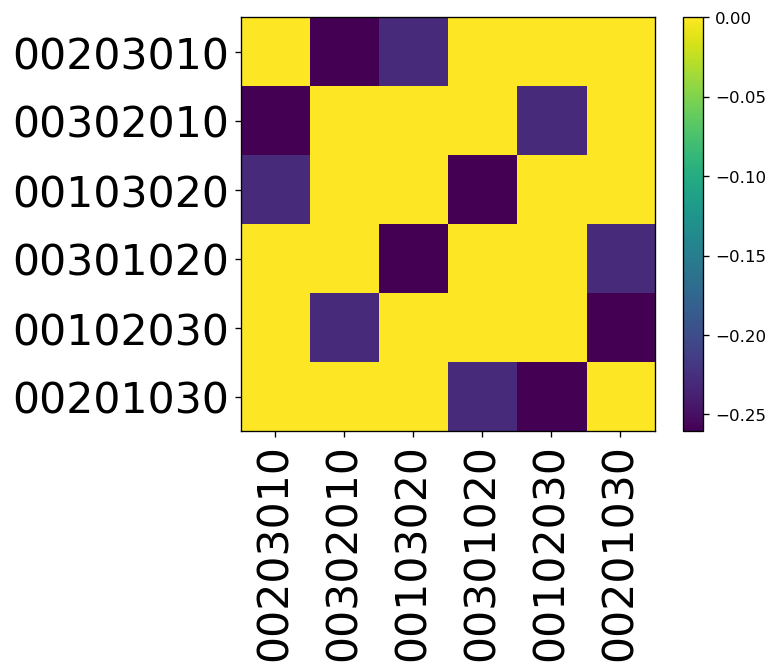

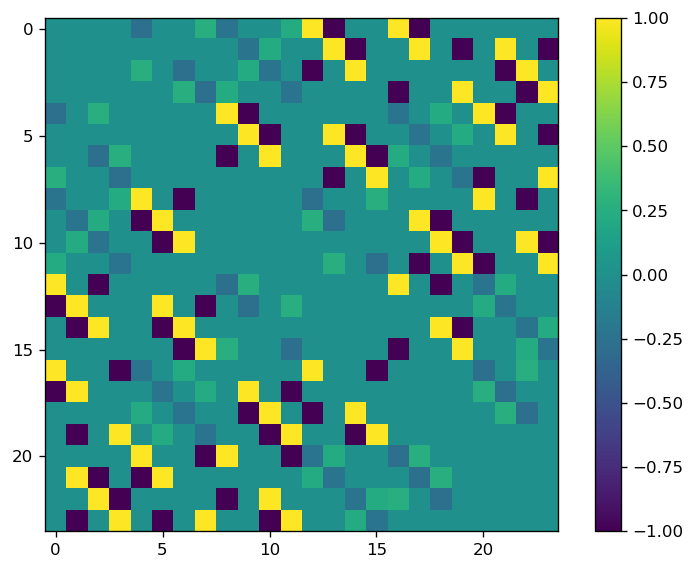

In [65]:
def adversary_k(cycles, k):
    shifted = {cycle: get_all_k_shift(cycle, k) for cycle in cycles}
    shift_mat = np.zeros((len(cycles), len(cycles))) 
    for cycle, shifts in shifted.items():
        for shift in shifts:
            
            shift_mat[cycles.index(cycle), cycles.index(shift)] = 1
    return shift_mat


def min_fill(adv, diffs, mask=None):
    n = diffs.shape[0] // adv.shape[0] 
    if mask is None:
        mask = np.zeros(adv.shape)
        for i in range(mask.shape[0]):
            for j in range(mask.shape[1]):
                if adv[i,j] == 0:
                    mask[i,j] = 1
    visualize(mask)
    extra = cp.Variable(adv.shape, symmetric=True)
    constraints = [cp.multiply(mask, extra) == extra]
    adv_diff = cp.multiply(cp.kron((adv + extra), np.ones((n,n))), diffs)
    val = np.linalg.eigvalsh(np.kron(adv, np.ones((n,n)))* diffs)[-1]
    opt_prob = cp.Problem(cp.Minimize(cp.lambda_max(adv_diff)/val), constraints)
    opt_prob.solve(verbose=True)
    return extra.value, adv_diff.value

                          
adv_k = adversary_k(cycles, 1) + adversary_k(cycles, 2) + adversary_k(cycles, 0) 
visualize(adv_k)

extra, adv_diff = min_fill(adv_k, diffs)
visualize(extra, (cycle_labels, cycle_labels))
visualize(adv_diff)

In [45]:
def get_eig_outer(M, r=5):
    vals, vects = np.linalg.eigh(M)   
    vals = np.round(vals, r)
    vects = np.round(vects, r)
    outers = [np.outer(vects[:, i], vects[:, i]) for i in range(vects.shape[0])]
    return vals, vects, outers   


In [55]:
def visualize_outers(mat, row_labels=None):
    if row_labels is None:
        row_labels = list(range(mat.shape[0]))
    vals, vects, outers = get_eig_outer(mat)
    vals = np.round(vals, 4)
    vals_str = [str(val) for val in vals]
    for val, outer in zip(vals, outers):
        visualize(outer, labels=(vals_str, row_labels), title=str(val))

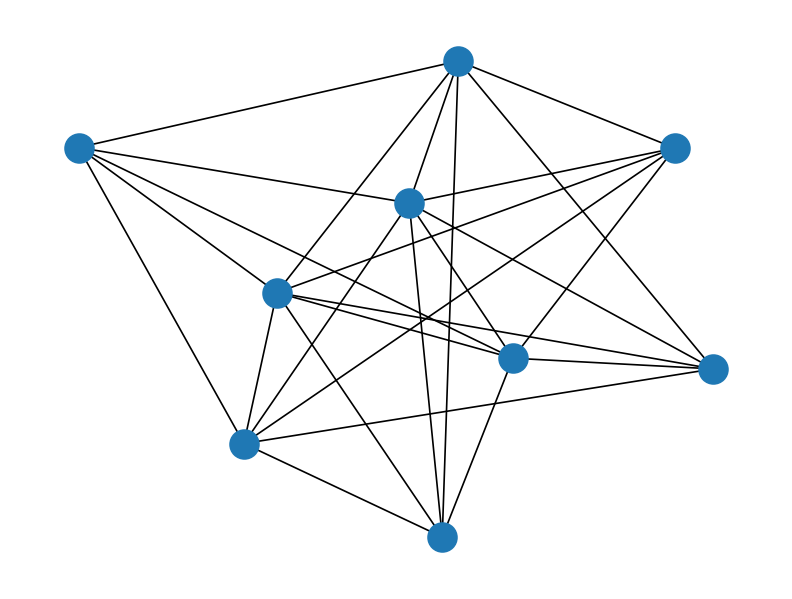

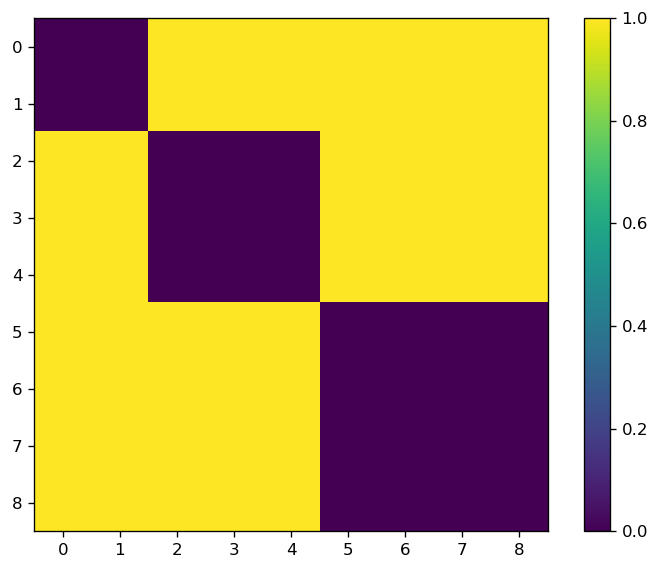

[-3.51149862e+00 -2.33717545e+00 -1.12037926e-15 -5.56073485e-16
 -1.75510286e-16  1.03444714e-16  2.60421776e-16  3.03177358e-16
  5.84867407e+00]


In [53]:
G = nx.complete_multipartite_graph(2,3,4)
nx.draw(G)
A = nx.adjacency_matrix(G).toarray()
visualize(A)
print(np.linalg.eigvalsh(A))

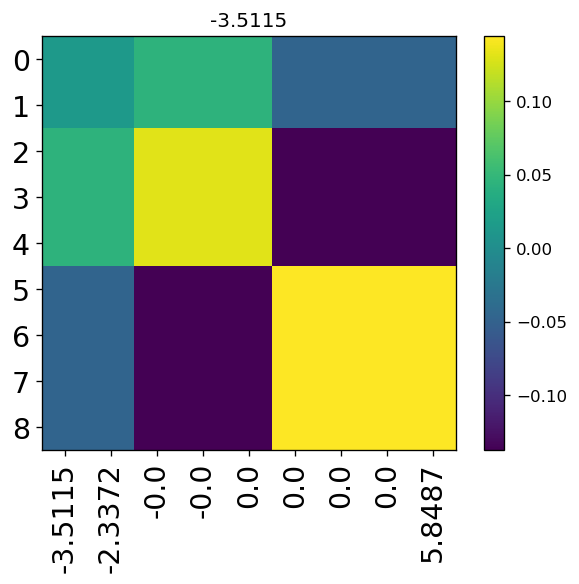

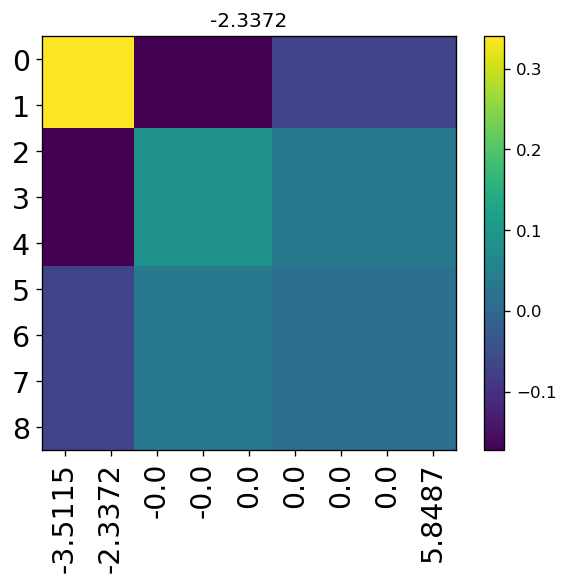

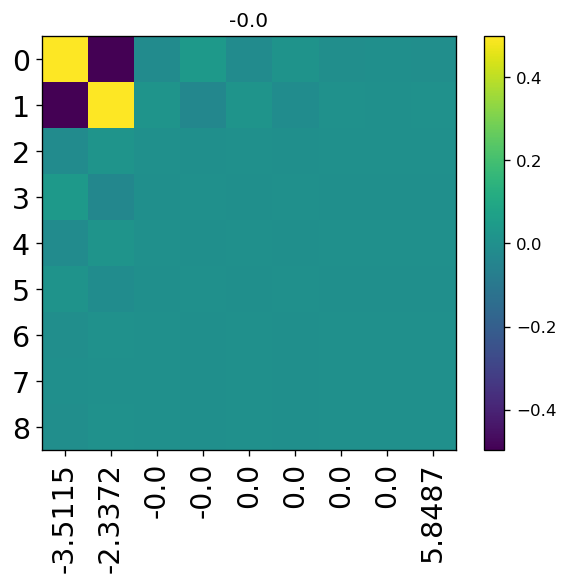

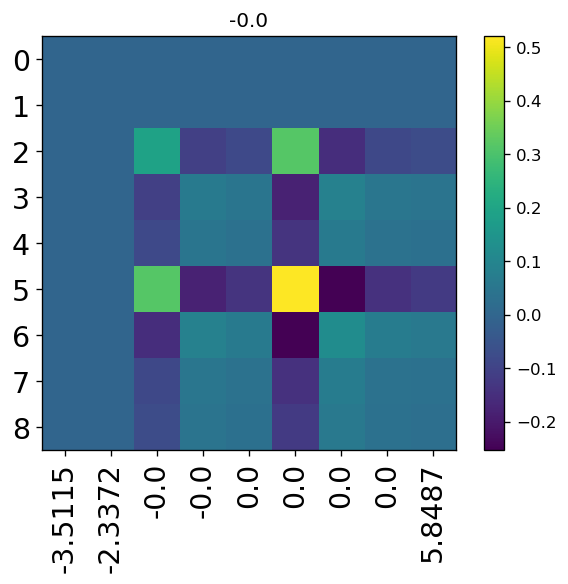

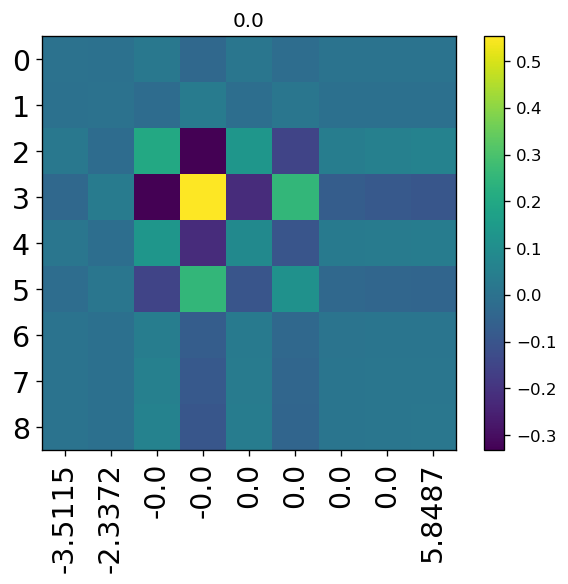

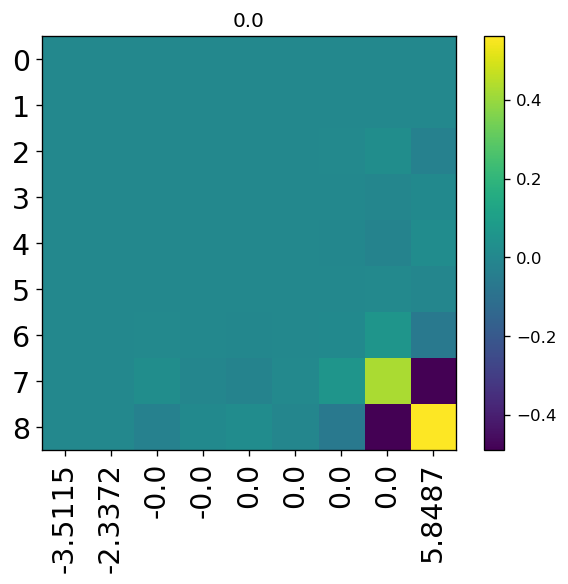

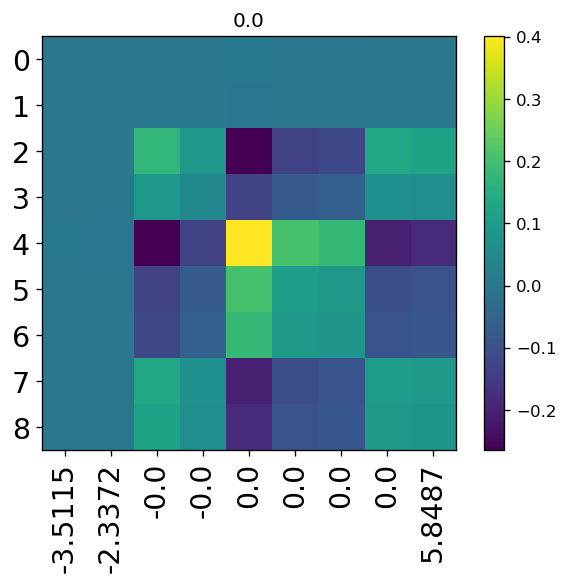

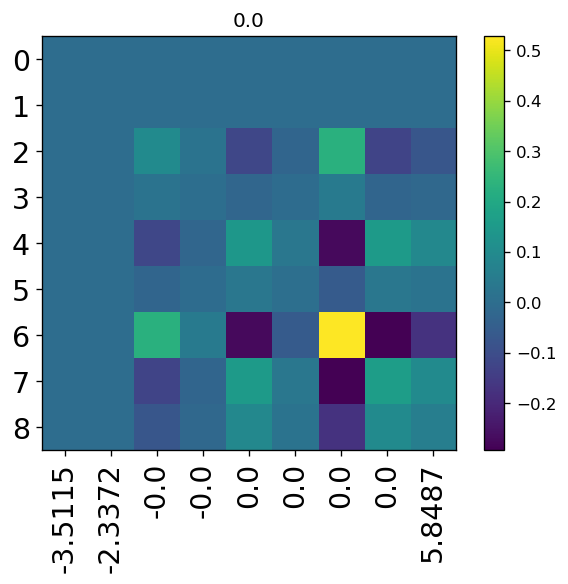

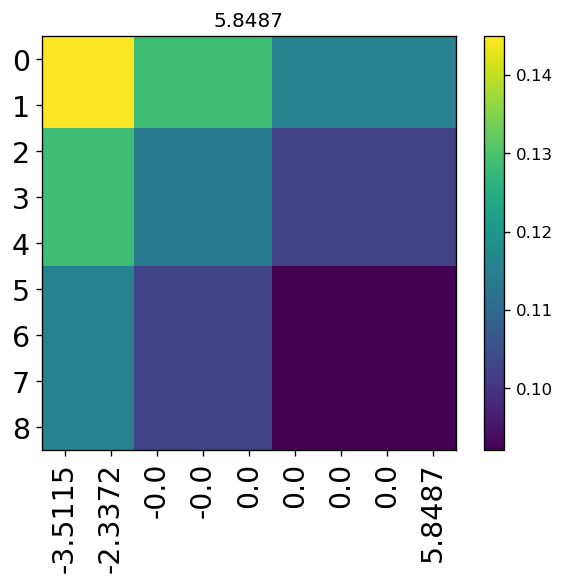

In [56]:
visualize_outers(A)

In [ ]:
la